<h1> Trabalho Prático - Aprendizado de Máquina </h1>
<h2>Wesley Marques Daniel Chaves </h2>
<p>O objetivo do trabalho é implementar uma rede neuronal com 3 camadas, sendo uma camada de entrada, na qual cada unidade representa uma dimensão da entrada, uma camada interna, em que cada unidade representa uma transformação dos dados, e uma camada de saída, na qual cada unidade representa a chance da saída correspondente ser a correta.</p>
<p>O conjunto de dados corresponde a 5 mil instâncias do banco de dados MNIST, onde cada entrada é uma matriz 28x28 que representa a imagem de um dígito decimal escrito manualmente, e a saída o digito representado na imagem. Desse modo, a tarefa da rede neuronal é ser capaz de classificar cada entrada (digito escrito manualmente) em cada uma das 10 classes (digitos de 0 a 9).</p>

In [252]:
# importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

<h3>Dados - Obtenção e Tratamento</h3>
<p>Inicialmente, iremos carregar os dados disponíveis no arquivo data_tp1, onde cada linha é uma instância, sendo a primeira coluna a sua classe (saída), e a colunas restantes a intensidade da cor de cada pixel da imagem do digito escrito manualmente (entrada).</p>

In [253]:
dataset = np.loadtxt('data_tp1', delimiter=',')
X = dataset[:, 1:]
y = dataset[:, 0]

<p>Para realizarmos a divisão dos dados em conjunto de treinamento, conjunto de validação e conjunto de teste, é importante entender a distribuição dos dados, de modo a obter dados representativos em cada um desses conjuntos. Desse modo, iremos plotar um histograma de nossos dados, onde o eixo x é o digito e o eixo y a quantidade total daquele digito presente nos dados.</p>

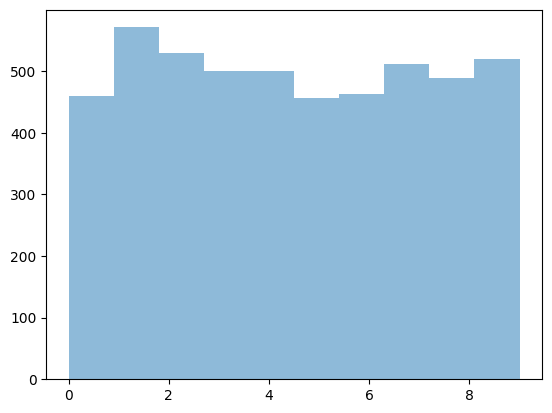

In [254]:
plt.hist(y, alpha=0.5)
plt.show()

<p>Como a distribuição é aproximadamente uniforme, não vejo necessidade de estratificação, desse modo, iremos utilizar a função train_test_split para obter cada um dos conjuntos citados anteriormente. Além disso, iremos plotar o histograma para cada um dos conjuntos, evidenciando que todos eles possuem quantidades aproximadamente iguais de digitos.</p>

In [255]:
# criação do test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# criação do validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

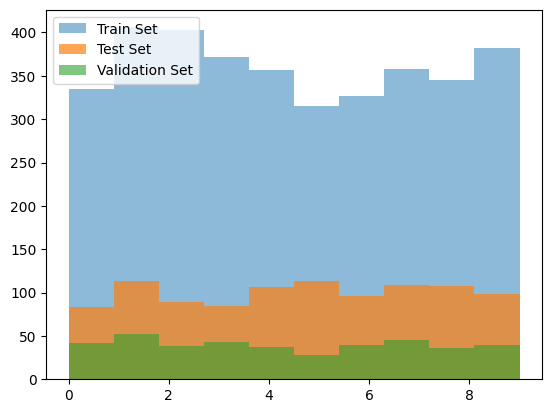

In [256]:
plt.hist(y_train, alpha=0.5, label='Train Set')
plt.hist(y_test, alpha=0.7, label='Test Set')
plt.hist(y_valid, alpha=0.6, label='Validation Set')
plt.legend()
plt.show()

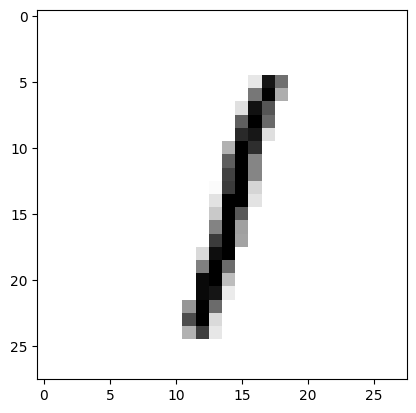

In [257]:
# plotando a imagem de um dígito aleatório
np.random.seed(42)
index = np.random.randint(0, len(X_train))

some_digit = X_train[index]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.show()

In [258]:
# classe do digito
y_train[index]

1.0

<p>Como cada uma das dimensões das entradas representam intensidades de cor para cada pixel, seus valores variam de 0 a 255, gerando uma diferença relativamente grande em termos de escala. Como o gradiente descendente performa melhor em dados com escalas parecidas, iremos aplicar o Min-Max scalling para obter valores variando de 0 e 1 apenas. Note que aplicamos o método fit_transform apenas nos dados de treinamento, não ocorrendo nenhum vazamento de informação dos dados de teste e validação para os dados de treinamento.</p>

In [259]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

<h3>Modelo - Criação e Treinamento</h3>
<p>Em nosso modelo, foi utilizado a função sigmoide para obter a não-linearidade na camada interna e a função softmax na camada de saída, responsável por calcular as exponenciais de seus inputs e normalizá-las, de forma que a soma das chances da entrada pertencer a cada uma das 10 classes seja 1. Além disso, a função de perda a ser minimizada é a cross entropy.</p>

In [267]:
def create_model(n_neurons, learning_rate):
    # definição
    model = keras.models.Sequential([
        keras.layers.Input(shape=(784,)), # input layer
        keras.layers.Dense(n_neurons, activation='sigmoid'), # hidden layer
        keras.layers.Dense(10, activation='softmax') # output layer
    ])
    # compilação
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=['accuracy'])
    return model

In [268]:
def train_model(X_train, X_valid, y_train, y_valid, model, batch_size):
    history = model.fit(X_train, y_train, 
                        epochs=200, 
                        batch_size=batch_size, 
                        validation_data=(X_valid, y_valid))
    return history

In [301]:
# função que salva os modelos na memória
def save_models(param_distribs, X_train, X_valid, y_train, y_valid):
    for n_neurons in param_distribs['n_neurons']:
        for learning_rate in param_distribs['learning_rate']:
            for batch_size in param_distribs['batch_size']:
                
                # cria e treina cada modelo
                model = create_model(n_neurons, learning_rate)
                history = train_model(X_train, X_valid, y_train, y_valid, model, batch_size)
                
                # salva o modelo e seu histórico
                folder = f'saved_models/model_{n_neurons}_{learning_rate}_{batch_size}'
                if not os.path.exists(folder):
                    os.makedirs(folder)
                model_filename = f'{folder}/model.joblib'
                history_filename = f'{folder}/history.joblib'
                joblib.dump(model, model_filename)
                joblib.dump(history.history, history_filename)

In [302]:
# função que carrega os modelos da memória
def load_models(param_distribs):
    models = []
    for n_neurons in param_distribs['n_neurons']:
        for learning_rate in param_distribs['learning_rate']:
            for batch_size in param_distribs['batch_size']:
                
                folder = f'saved_models/model_{n_neurons}_{learning_rate}_{batch_size}'
                # carrega o modelo e seu histórico
                model_filename = f'{folder}/model.joblib'
                history_filename = f'{folder}/history.joblib'
                model = joblib.load(model_filename)
                history = joblib.load(history_filename)
                models.append({'model': model, 'history': history, 'n_neurons': n_neurons, 'learning_rate': learning_rate, 'batch_size': batch_size})
    
    return models

In [303]:
# função que plota os gráficos de todas as combinações de batch size e learning rate para cada número de neurônios
def plot(n_neurons, models, param_distribs):
    fig, axs = plt.subplots(len(param_distribs['batch_size']), len(param_distribs['learning_rate']), figsize=(20, 15))
    fig.suptitle(f'Number of Neurons: {n_neurons}', fontsize=20, fontweight='bold')
    
    for i, batch_size in enumerate(param_distribs['batch_size']):
        for j, learning_rate in enumerate(param_distribs['learning_rate']):
            for model in models:
                if(model['n_neurons']==n_neurons and model['batch_size']==batch_size and model['learning_rate']==learning_rate):
                    # plota o erro empírico
                    axs[i, j].plot(model['history']['loss'], label=f'loss (lr={learning_rate})')
                    axs[i, j].plot(model['history']['val_loss'], label=f'val_loss (lr={learning_rate})')
                    
                    if batch_size == param_distribs['batch_size'][0]:
                        axs[i, 1].set_title(f'Gradient Descent', fontsize=16, fontweight='bold')
                    if batch_size == param_distribs['batch_size'][1]:
                        axs[i, 1].set_title(f'Mini-Batch: 50', fontsize=16, fontweight='bold')
                    if batch_size == param_distribs['batch_size'][2]:
                        axs[i, 1].set_title(f'Mini-Batch: 10', fontsize=16, fontweight='bold')
                    if batch_size == param_distribs['batch_size'][3]:
                        axs[i, 1].set_title(f'Stochastic Gradient Descent', fontsize=16, fontweight='bold')
                    axs[i, j].set_ylabel('Empirical Error')
                    axs[i, j].set_xlabel('Epochs')
                    axs[i, j].legend(loc='upper right')

    plt.subplots_adjust(hspace=0.5)
    plt.show()

<p>Abaixo temos todas as combinações de número de neurônios, taxa de aprendizado e tamanho do batch que devemos analisar, gerando no total 36 modelos diferentes para treinarmos e avaliarmos.</p>

In [304]:
param_distribs = {
    'n_neurons': [25, 50, 100],
    'learning_rate': [0.5, 1.0, 10.0],
    'batch_size': [len(X_train), 50, 10, 1]
}

In [292]:
# treina cada um dos 36 modelos, salva-os na memória e os recupera posteriormente
save_models(param_distribs, X_train, X_valid, y_train, y_valid)
models = load_models(param_distribs)

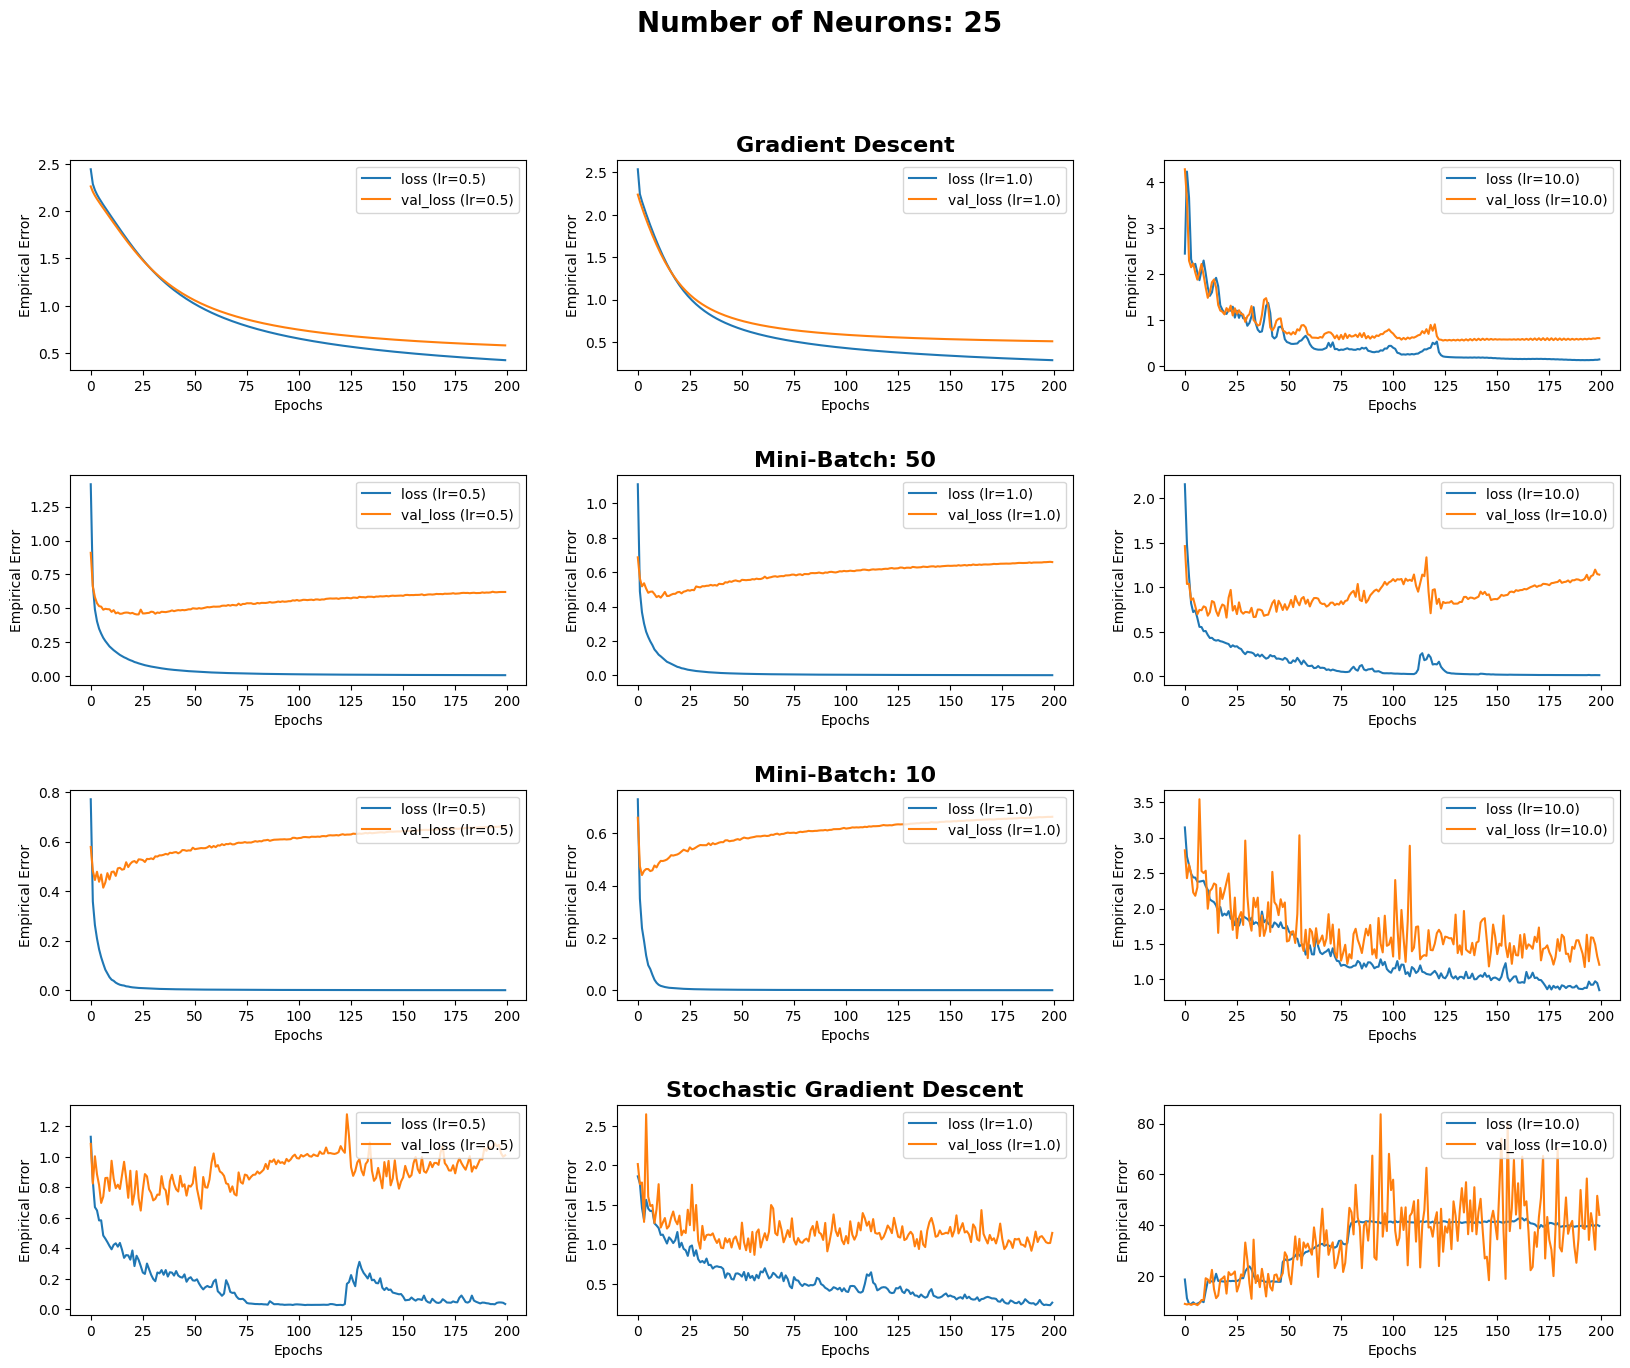

In [293]:
plot(25, models, param_distribs)

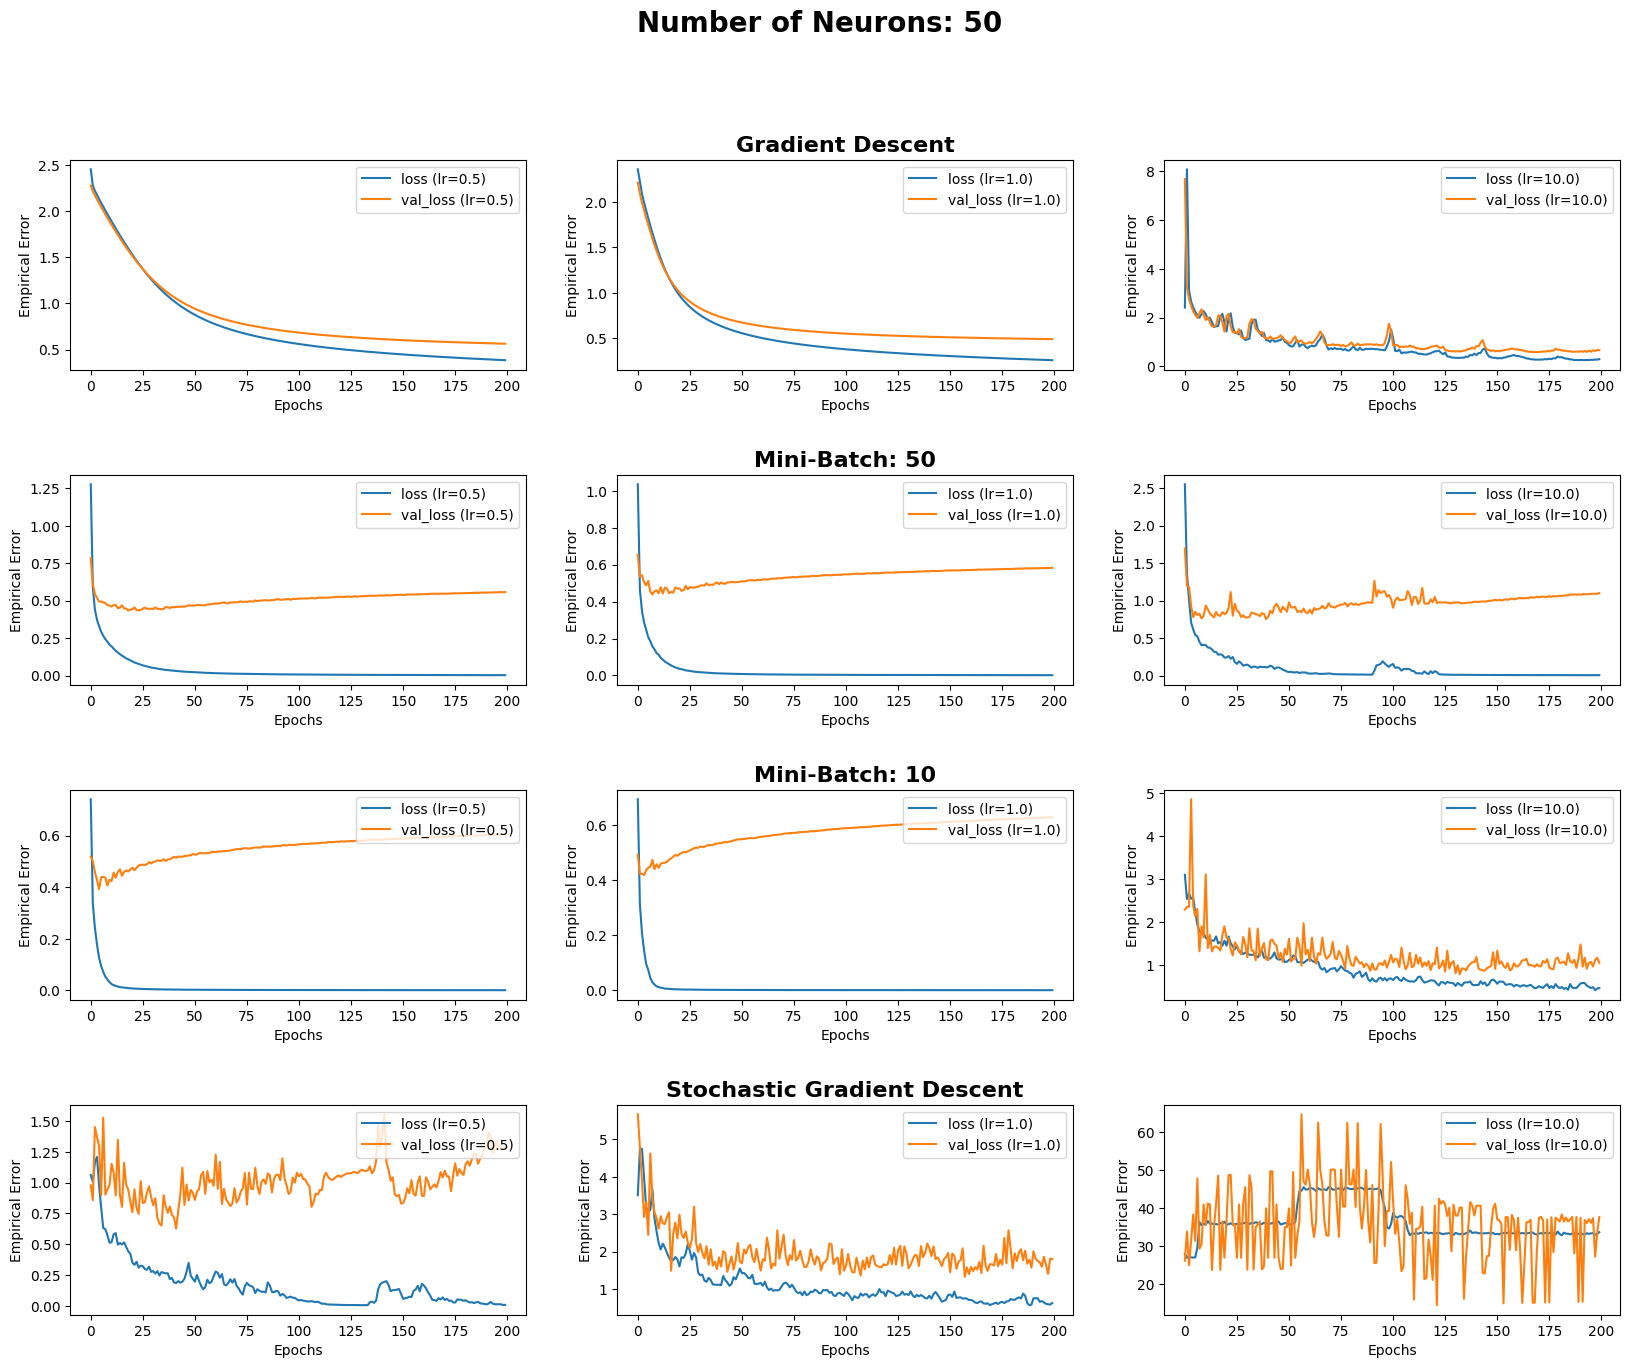

In [294]:
plot(50, models, param_distribs)

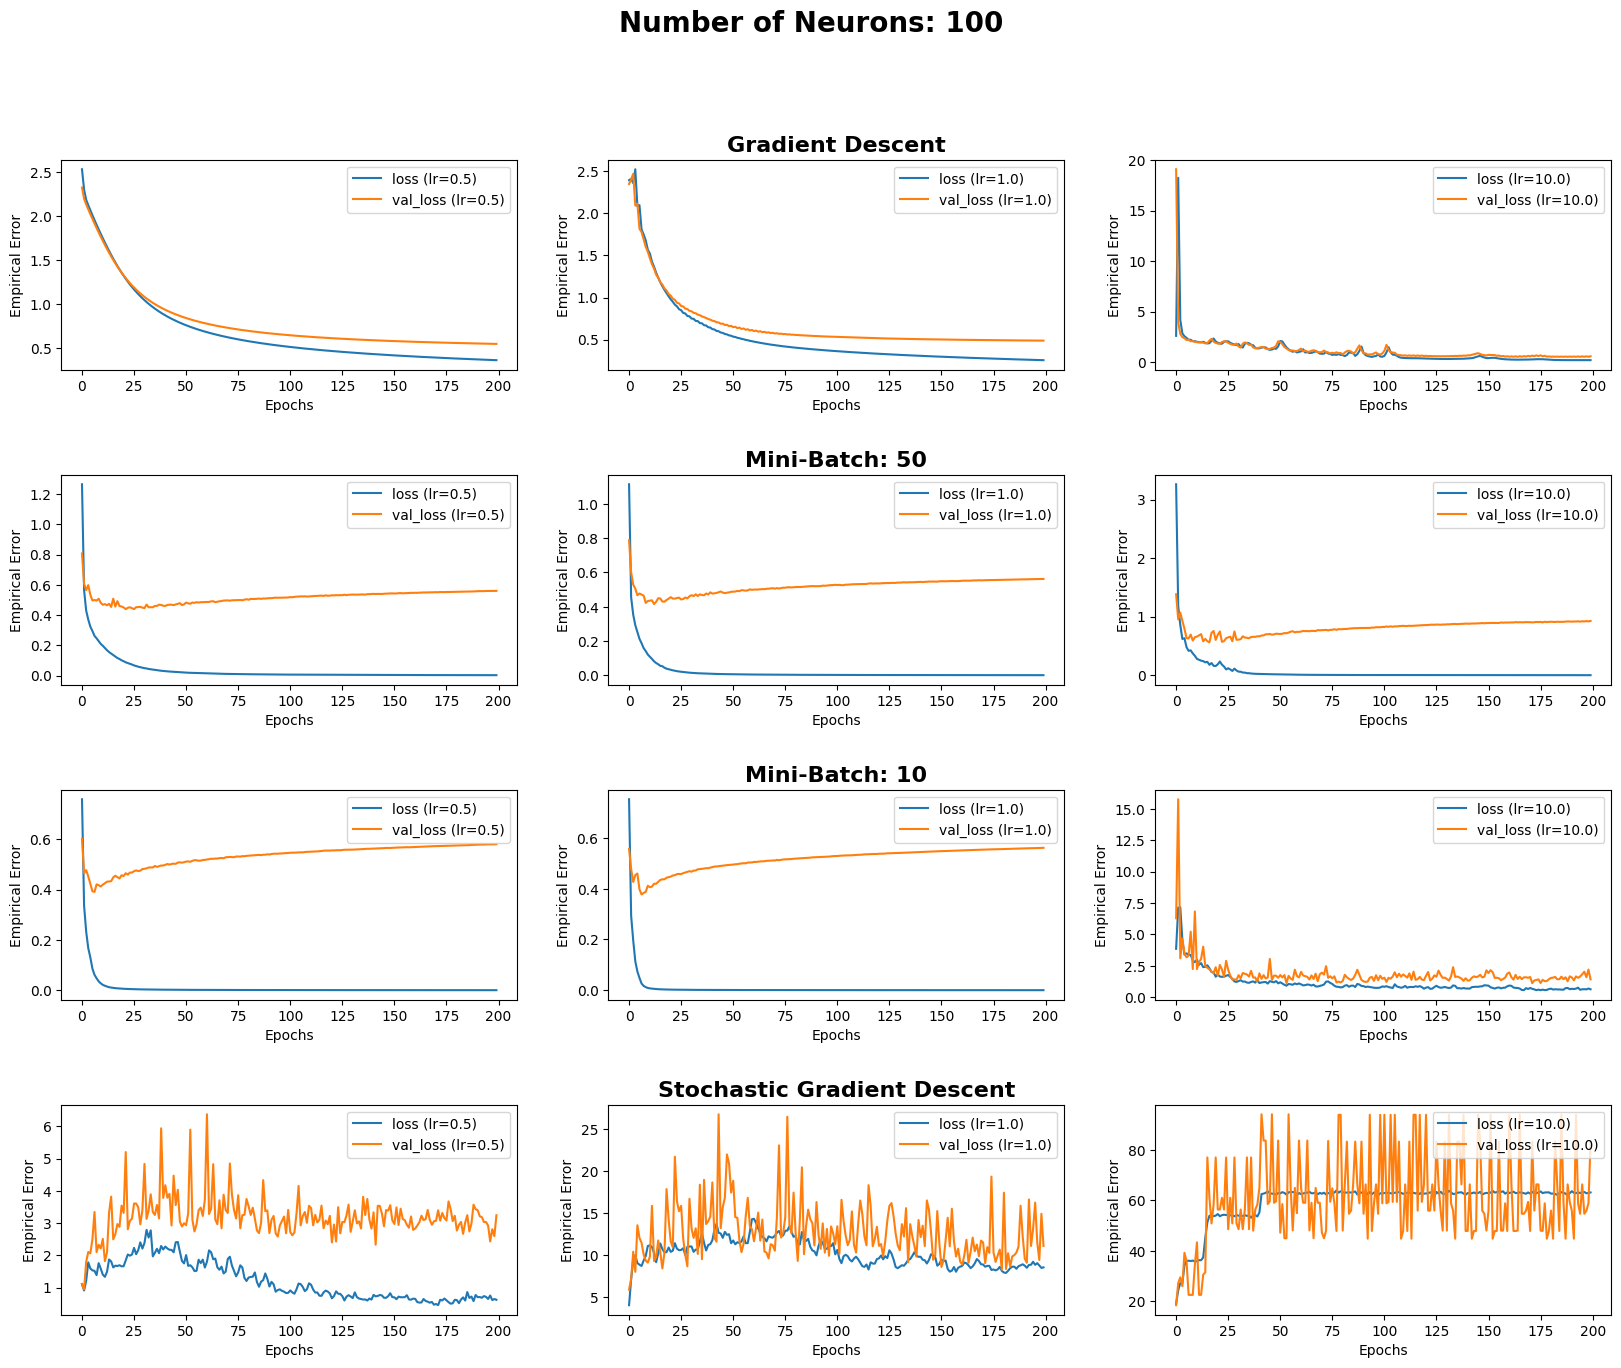

In [295]:
plot(100, models, param_distribs)

<p>Analisando a taxa de aprendizado, vemos que quanto maior ela é, maiores os valores para os quais o erro empírico converge. Particularmente, vemos que os modelos que implementam o SGD e possuem taxa de aprendizado 10.0 foram os piores, fazendo com que o erro empírico convirja para valores muito elevados. Este fato leva a crer que, devido a alta taxa de aprendizado fazer o algoritmo "pular" erradicamente pelo espaço de parâmetros, ele saiu de valores menores para o erro empírico, passando por mínimos locais e posteriormente "caindo" em mínimos locais até piores que os anteriores. Ou seja, a alta taxa de aprendizado aliada com o SGD levou aos piores modelos.</p> 
<p>Com relação ao tamanho do batch, vemos que quanto menor o seu tamanho, maiores os valores para os quais o erro empírico converge e maior a variação do erro durante as épocas. Quanto maior o tamanho do batch, maior a quantidade de instâncias para o cálculo de gradiente, tornando o modelo menos suscetível a instâncias específicas, calculando com maior precisão os novos parâmetros em direção ao mínimo global. Desse modo, embora os algoritmos com maiores batch tenham demorado mais épocas para diminuir o erro empírico, sua descida é bem suave, sem variações como nos outros algoritmos com tamanhos de batch menores.</p>
<p>Para os algoritmos utilizando Mini-Batch, vemos uma combinação da diminuição rápida com uma diminuição "suave" do erro empírico, levando a resultados mais promissores quando consideramos taxas de aprendizado de 0.5 e 1.0. No entanto, nesses modelos vemos uma discrepância muito maior entre o erro empírico dos dados de treinamento e o erro empírico dos dados de validação, ocorrendo ainda um aumento do erro de validação conforme o erro dos dados de treino convergiam para o mínimo global. Este fato nos leva a perceber que esses modelos são mais sobre-ajustados que todos os outros, porém, mesmo com o overfitting, o erro observado no conjunto de validação ainda são menores que o mesmo erro observado nos outros modelos.</p>
<p>Uma estratégia para lidar com esse sobre-ajuste é aplicar o early stopping, que irá encerrar o treinamento da rede neuronal após uma quantidade x de épocas em que não foi observado melhora nos erros no conjunto de validação, diminuindo a utilização de recursos computacionais. No entanto, não aplicamos tal estratégia para que possamos discutir justamente a sua aplicabilidade nesses casos.</p>

<h3>Modelo - Avaliação</h3>
<p>Para cada modelo, iremos calcular a acurácia e o F1 score no conjunto de validação e selecionar o melhor conjunto de parâmetros e hiperparâmetros para cada métrica.</p>
<p>Como a distribuição das classes é aproximadamente uniforme, a escolha de um classificador que privilegia uma classe em oposição das outras não irá ter uma acurácia alta, desse modo, tal métrica alta em nosso conjunto de dados é uma medida confiável de performance de nossos modelos.</p>
<p>Intuitivamente, precision é a chance de uma entrada classificada como pertencente a uma determinada classe ser realmente dessa classe. Já recall é a chance de uma entrada que realmente pertence a uma classe ser classificada como tal. Idealmente, queremos que a chance em ambos os casos seja 1, porém, existe um trade-off entre precision e recall que torna dificil tal objetivo. Uma métrica que busca sintetizar precision e recall é o F1 score, que é a média harmônica de ambos os argumentos. Desse modo, um F1 score alto é alcançado quando ambos precision e recall também são altos. Por isto escolhemos avaliar diretamente o F1 score de nossos modelos.</p>

In [278]:
# retorna o modelo que possui a maior acurácia
def evaluate_accuracy(models, X, y):
    better_model_accuracy = None
    better_accuracy = 0

    for model in models:
        y_pred_proba = model['model'].predict(X)
        y_pred = np.argmax(y_pred_proba, axis=-1)
        accuracy = accuracy_score(y, y_pred)
        if accuracy > better_accuracy:
            better_model_accuracy = model
            better_accuracy = accuracy

    return better_model_accuracy, better_accuracy

# retorna o modelo que possui o maior F1 score
def evaluate_f1(models, X, y):
    better_model_f1 = None
    better_f1 = 0

    for model in models:
        y_pred_proba = model['model'].predict(X)
        y_pred = np.argmax(y_pred_proba, axis=-1)
        f1 = f1_score(y, y_pred, average="macro")
        if f1 > better_f1:
            better_model_f1 = model
            better_f1 = f1

    return better_model_f1, better_f1

In [279]:
better_model_accuracy, better_accuracy = evaluate_accuracy(models, X_valid, y_valid)
better_model_f1, better_f1 = evaluate_f1(models, X_valid, y_valid)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━

In [280]:
print(f"Número de neurônios: {better_model_accuracy['n_neurons']}")
print(f"Taxa de aprendizado: {better_model_accuracy['learning_rate']}")
print(f"Tamanho do batch: {better_model_accuracy['batch_size']}")
print(f"Acurácia: {better_accuracy}")

Número de neurônios: 100
Taxa de aprendizado: 1.0
Tamanho do batch: 10
Acurácia: 0.9025


In [281]:
print(f"Número de neurônios: {better_model_f1['n_neurons']}")
print(f"Taxa de aprendizado: {better_model_f1['learning_rate']}")
print(f"Tamanho do batch: {better_model_f1['batch_size']}")
print(f"F1 score: {better_f1}")

Número de neurônios: 100
Taxa de aprendizado: 1.0
Tamanho do batch: 10
F1 score: 0.9001000951547423


<p>Para ambas as métricas, o melhor modelo obtido possui 100 neurônios na camada interna e foi treinado com a taxa de aprendizado de 1.0 e tamanho do batch de 10 (Mini-Batch). Como haviamos discutido anteriormente, vemos que a acurácia realmente é uma boa métrica para avaliar o modelo, pois se não fosse, muito provavelmente veríamos uma discrepância entre o melhor modelo considerando a acurácia e o melhor modelo considerando o F1 score.</p>
<p>Por fim, iremos avaliar a acurácia e o F1 score de nosso modelo escolhido nos dados de teste, permitindo avaliarmos o modelo em dados que não participaram de nenhuma fase de treinamento e seleção.</p>

In [296]:
y_pred_proba = better_model_f1['model'].predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=-1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [297]:
print(f'Accuracy: {accuracy}')
print(f'F1_score: {f1}')

Accuracy: 0.94
F1_score: 0.940228649449805


In [298]:
confusion_matrix(y_test, y_pred)

array([[ 82,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0, 111,   0,   1,   0,   1,   0,   0,   0,   0],
       [  0,   0,  85,   2,   1,   0,   0,   0,   0,   1],
       [  0,   0,   1,  76,   0,   4,   0,   1,   3,   0],
       [  0,   1,   0,   0,  99,   1,   1,   0,   2,   2],
       [  1,   1,   0,   2,   0, 104,   1,   1,   2,   1],
       [  3,   1,   2,   0,   0,   2,  87,   0,   1,   0],
       [  0,   2,   1,   0,   0,   2,   0, 102,   0,   2],
       [  0,   2,   0,   0,   1,   3,   0,   0, 102,   0],
       [  1,   0,   0,   1,   4,   0,   0,   0,   0,  92]])

<p>Acima temos a matrix de confusão do modelo quando o conjunto de teste é utilizado. É possível observar claramente que as maiores quantidades estão na diagonal principal, que é onde está indicando a quantidade dos verdadeiros positivos (TP) para cada classe, que é representada por uma linha na matriz.</p>
<p>Curiosamente, vemos que o modelo performou melhor em ambas as métricas no conjunto de teste do que no conjunto de validação. Considero que tal aumento possa ser devido a uma pequena maior semelhança na proporção das classes nos dados de teste e nos dados de treinamento.</p>

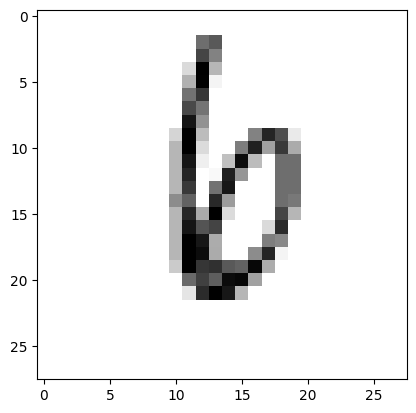

In [299]:
# utilizando o modelo escolhido para classificar uma entrada aleatória
np.random.seed(42)
index = np.random.randint(0, len(X_test))

some_digit = X_test[index]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.show()

In [300]:
y_pred_proba = better_model_f1['model'].predict(np.expand_dims(X_test[index], axis=0))
y_pred = np.argmax(y_pred_proba, axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([6])